In [1]:
!pip install yellowbrick

     -------------------------------------- 282.6/282.6 kB 4.4 MB/s eta 0:00:00


In [19]:
import pandas as pd
import numpy as np
import warnings 
import time
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, pairwise_distances
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from yellowbrick.style import set_palette

In [20]:
warnings.filterwarnings('ignore')

In [21]:
data =  pd.read_csv('data.csv',  engine = 'python',  on_bad_lines = 'skip', index_col=[0])

In [22]:
data.head()

,customer_unique_id,order_purchase_timestamp,price,review_score
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,124.99,4
1,9eae34bbd3a474ec5d07949ca7de67c0,2017-11-09 00:50:13,112.99,1
3,3c799d181c34d51f6d44bbbc563024db,2017-05-07 20:11:26,124.99,3
4,23397e992b09769faf5e66f9e171a241,2018-02-03 19:45:40,106.99,4
5,567ab47ca4deb92d46dbf54dce07d0a7,2017-03-23 15:10:17,126.99,4


## 2.1 calcul de RFM

In [23]:
last_buy = data['order_purchase_timestamp'].max()
print(last_buy)

2018-09-03 09:06:57


In [24]:
data['recence'] = (pd.to_datetime(last_buy) - pd.to_datetime(data['order_purchase_timestamp'])).dt.days

In [8]:
# Calcul de la fréquence pour chaque client
freq = data.groupby('customer_unique_id')['order_purchase_timestamp'].count().reset_index()
freq.columns = ['customer_unique_id', 'frequence']
data = pd.merge(data, freq, on='customer_unique_id')

In [9]:
# Calcul du montant total dépensé pour chaque client
montant = data.groupby('customer_unique_id')['price'].sum().reset_index()
montant.columns = ['customer_unique_id', 'montant_total']
data = pd.merge(data, montant, on='customer_unique_id')

In [10]:
data.head()

,customer_unique_id,order_purchase_timestamp,price,review_score,recence,frequence,montant_total
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,124.99,4,474,1,124.99
1,9eae34bbd3a474ec5d07949ca7de67c0,2017-11-09 00:50:13,112.99,1,298,1,112.99
2,3c799d181c34d51f6d44bbbc563024db,2017-05-07 20:11:26,124.99,3,483,1,124.99
3,23397e992b09769faf5e66f9e171a241,2018-02-03 19:45:40,106.99,4,211,1,106.99
4,567ab47ca4deb92d46dbf54dce07d0a7,2017-03-23 15:10:17,126.99,4,528,1,126.99


In [11]:
data_rfm = data.loc[:, ['recence', 'frequence', 'montant_total']].copy()

In [12]:
data_rfm.head()

,recence,frequence,montant_total
0,474,1,124.99
1,298,1,112.99
2,483,1,124.99
3,211,1,106.99
4,528,1,126.99


In [13]:
# Scale les données
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(data_rfm)

In [14]:
X = rfm_scaled

In [15]:
def davies_bouldin_index(X, labels):
    # Calculer les centres de gravité de chaque cluster
    centers = []
    for i in range(len(set(labels))):
        center = X[labels == i].mean(axis=0)
        centers.append(center)

    # Calculer la matrice de distance entre les centres de gravité
    center_distances = pairwise_distances(centers)

    # Calculer la matrice de distance entre les points de données et les centres de gravité
    point_distances = pairwise_distances(X, centers)

    # Calculer la distance moyenne pour chaque cluster
    mean_distances = []
    for i in range(len(set(labels))):
        mean_distance = point_distances[labels == i, i].mean()
        mean_distances.append(mean_distance)

    # Calculer l'indice de Davies-Bouldin
    db_index = 0
    for i in range(len(set(labels))):
        max_db = -1
        for j in range(len(set(labels))):
            if i != j:
                db = (mean_distances[i] + mean_distances[j]) / center_distances[i,j]
                if db > max_db:
                    max_db = db
        db_index += max_db

    return db_index / len(set(labels))

In [15]:
def performance(y_test, y_pred):
    mse = round(mean_squared_error(y_test, y_pred), 2)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
    r2 = round(r2_score(y_test, y_pred),2)
    print("MSE : ", mse, " RMSE: ", rmse, " R2 :",r2)
    return mse, rmse, r2

## 2.2 Clustering par K_means

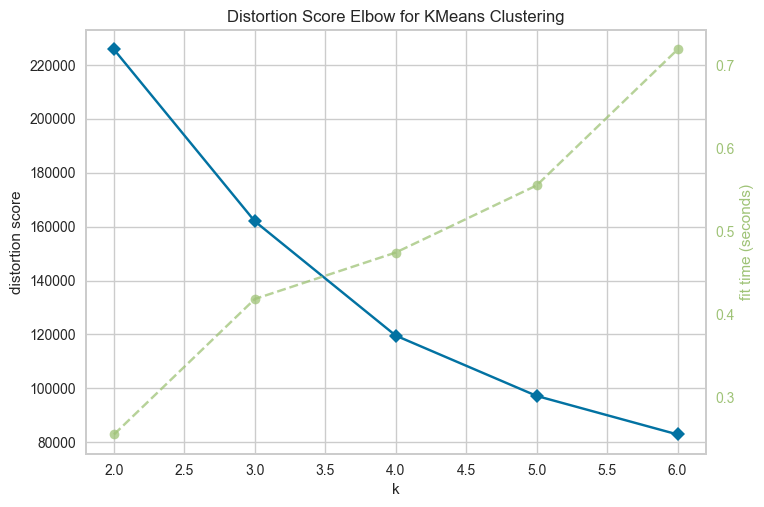

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,7))

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [17]:
# Sélection de nombre de cluster à 3.  Instantie Kmeans
start_time = time.time()
model = KMeans(n_clusters=3)
clusters = model.fit_predict(X)
end_time = time.time()
execution_time = end_time - start_time
print("temps d'exec Kmeans = ",execution_time )

temps d'exec Kmeans =  0.523193359375


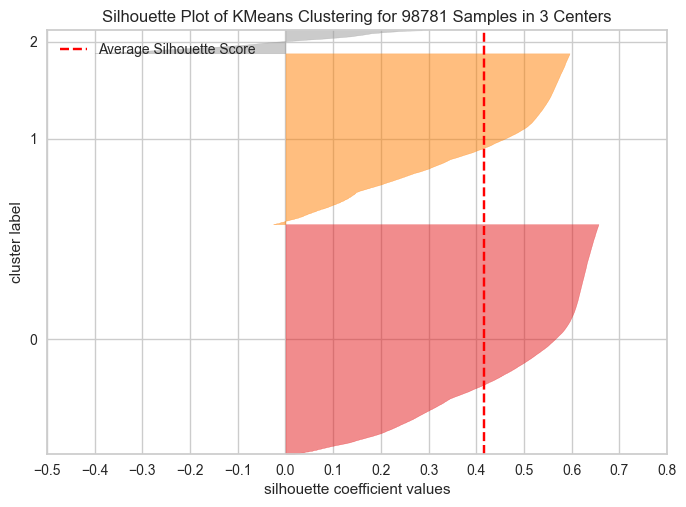

temps d'exec visu silouette =  224.77862238883972


In [40]:
start_time = time.time()
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data
end_time = time.time()
execution_time = end_time - start_time
print("temps d'exec visu silouette = ",execution_time )

In [45]:
# Calculer l'indice de Davies-Bouldin
start_time = time.time()
db_index = davies_bouldin_index(X, clusters)
print("L'indice de Davies-Bouldin est :", db_index)
end_time = time.time()
execution_time = end_time - start_time
print("temps d'exec DB = ",execution_time )

L'indice de Davies-Bouldin est : 0.9321024015609072
temps d'exec DB =  0.05684828758239746


In [33]:
# Visualize the clusters
data_rfm['Cluster'] = clusters
data_rfm.groupby('Cluster').agg({
    'recence': 'mean',
    'frequence': 'mean',
    'montant_total': ['mean', 'count']
}).round(2)

recence frequence montant_total       
           mean      mean          mean  count
Cluster                                       
0        131.99      1.07        109.01  53544
1        392.68      1.08        110.20  39861
2        252.37      2.39        654.38   5376

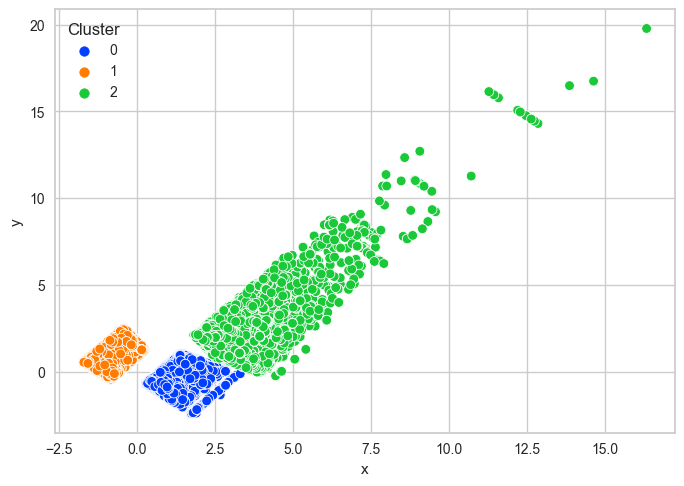

In [48]:
# Projection en 2D des données
pca = PCA(n_components=2)
pca.fit(rfm_scaled)
pca_data = pca.transform(rfm_scaled)

# Création d'un DataFrame avec les données projetées et l'identifiant de cluster
df = pd.DataFrame({'x': pca_data[:, 0], 'y': pca_data[:, 1], 'Cluster': clusters})

# Définition de la palette de couleurs
palette = sns.color_palette('bright', n_colors=len(df['Cluster'].unique()))

# Affichage des points avec la couleur correspondant à leur cluster
sns.scatterplot(data=df, x='x', y='y', hue='Cluster', palette=palette)

# Affichage du graphique
plt.show()

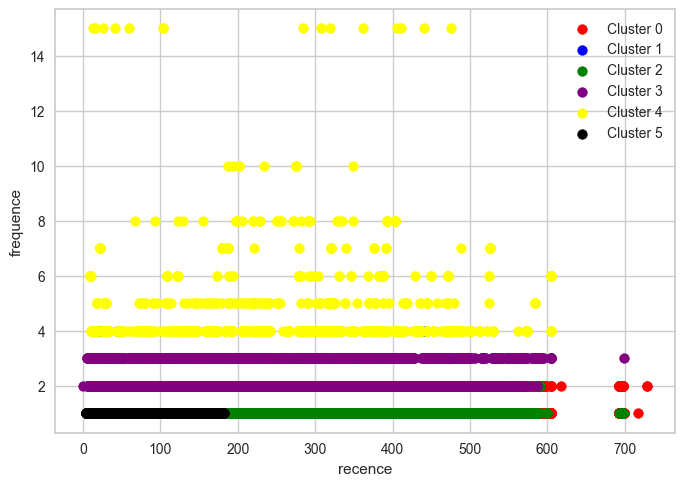

In [19]:
# create a scatter plot of recency and frequency means for each cluster
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 0, 'recence'], 
            data_rfm.loc[data_rfm['Cluster'] == 0, 'frequence'], 
            s=50, c='red', label='Cluster 0')
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 1, 'recence'], 
            data_rfm.loc[data_rfm['Cluster'] == 1, 'frequence'], 
            s=50, c='blue', label='Cluster 1')
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 2, 'recence'], 
            data_rfm.loc[data_rfm['Cluster'] == 2, 'frequence'], 
            s=50, c='green', label='Cluster 2')
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 3, 'recence'], 
            data_rfm.loc[data_rfm['Cluster'] == 3, 'frequence'], 
            s=50, c='purple', label='Cluster 3')
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 4, 'recence'], 
            data_rfm.loc[data_rfm['Cluster'] == 4, 'frequence'], 
            s=50, c='yellow', label='Cluster 4')
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 5, 'recence'], 
            data_rfm.loc[data_rfm['Cluster'] == 5, 'frequence'], 
            s=50, c='black', label='Cluster 5')

# add axis labels and legend
plt.xlabel('recence')
plt.ylabel('frequence')
plt.legend()
plt.show()

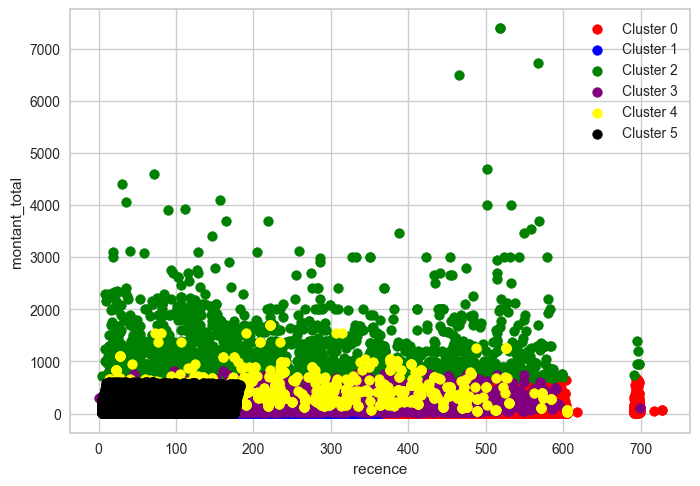

In [20]:
# create a scatter plot of recency and frequency means for each cluster
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 0, 'recence'], 
            data_rfm.loc[data_rfm['Cluster'] == 0, 'montant_total'], 
            s=50, c='red', label='Cluster 0')
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 1, 'recence'], 
            data_rfm.loc[data_rfm['Cluster'] == 1, 'montant_total'], 
            s=50, c='blue', label='Cluster 1')
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 2, 'recence'], 
            data_rfm.loc[data_rfm['Cluster'] == 2, 'montant_total'], 
            s=50, c='green', label='Cluster 2')
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 3, 'recence'], 
            data_rfm.loc[data_rfm['Cluster'] == 3, 'montant_total'], 
            s=50, c='purple', label='Cluster 3')
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 4, 'recence'], 
            data_rfm.loc[data_rfm['Cluster'] == 4, 'montant_total'], 
            s=50, c='yellow', label='Cluster 4')
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 5, 'recence'], 
            data_rfm.loc[data_rfm['Cluster'] == 5, 'montant_total'], 
            s=50, c='black', label='Cluster 5')

# add axis labels and legend
plt.xlabel('recence')
plt.ylabel('montant_total')
plt.legend()
plt.show()

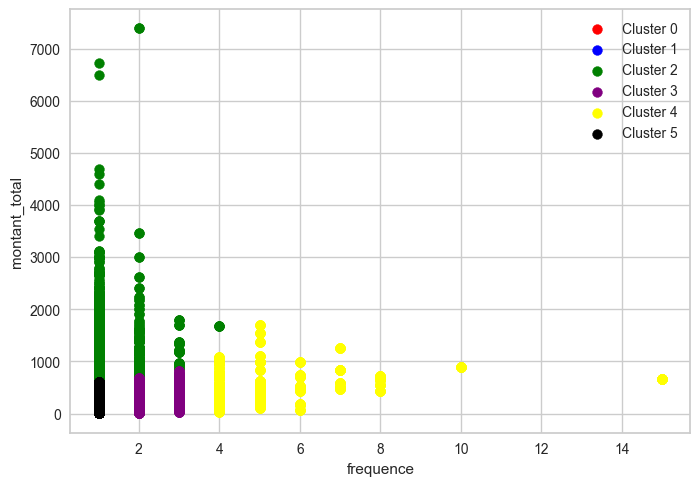

In [21]:
# create a scatter plot of recency and frequency means for each cluster
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 0, 'frequence'], 
            data_rfm.loc[data_rfm['Cluster'] == 0, 'montant_total'], 
            s=50, c='red', label='Cluster 0')
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 1, 'frequence'], 
            data_rfm.loc[data_rfm['Cluster'] == 1, 'montant_total'], 
            s=50, c='blue', label='Cluster 1')
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 2, 'frequence'], 
            data_rfm.loc[data_rfm['Cluster'] == 2, 'montant_total'], 
            s=50, c='green', label='Cluster 2')
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 3, 'frequence'], 
            data_rfm.loc[data_rfm['Cluster'] == 3, 'montant_total'], 
            s=50, c='purple', label='Cluster 3')
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 4, 'frequence'], 
            data_rfm.loc[data_rfm['Cluster'] == 4, 'montant_total'], 
            s=50, c='yellow', label='Cluster 4')
plt.scatter(data_rfm.loc[data_rfm['Cluster'] == 5, 'frequence'], 
            data_rfm.loc[data_rfm['Cluster'] == 5, 'montant_total'], 
            s=50, c='black', label='Cluster 5')

# add axis labels and legend
plt.xlabel('frequence')
plt.ylabel('montant_total')
plt.legend()
plt.show()

Evaluer le model par yellowbricks

## 2.3 Clustering par DBSCAN

In [18]:
# Calcul de la variation du coefficient de silhouette en fonction du nombre de clusters  (30min)
start_time = time.time()
eps_values = np.arange(0.1, 1.0, 0.1)
silhouette_scores = []
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    clusters = dbscan.fit_predict(X)
    if len(set(clusters)) > 1:
        silhouette_scores.append(silhouette_score(X, clusters))
end_time = time.time()
execution_time = end_time - start_time
print("temps d'exec DBSCAN = ",execution_time )

MemoryError: bad allocation

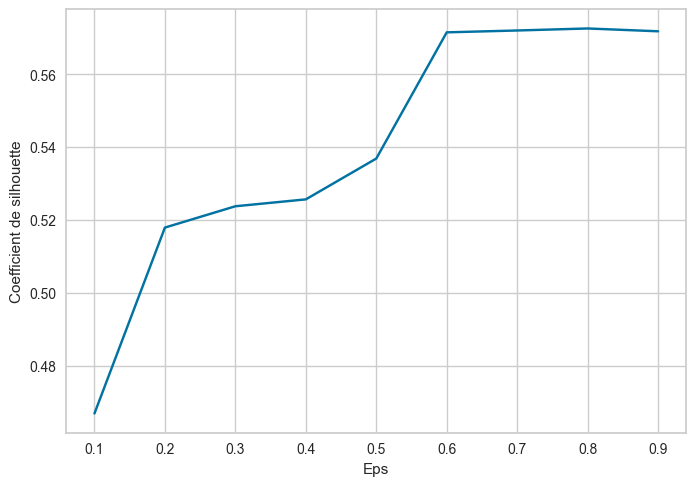

In [53]:
# Affichage de la courbe du coude
plt.plot(eps_values[:len(silhouette_scores)], silhouette_scores)
plt.xlabel('Eps')
plt.ylabel('Coefficient de silhouette')
plt.show()

In [17]:
# eps sélectionné par Eblow est 0.6  (temps = 100s, eps=0.6, min_samples=5,  temps = ???   esp = 2, min_samples=3)
start_time = time.time()
dbscan = DBSCAN(eps=0.8, n_samples=3)
dbscan.fit(X)
end_time = time.time()
execution_time = end_time - start_time
print("temps d'exec DBSCAN = ",execution_time )

TypeError: DBSCAN.__init__() got an unexpected keyword argument 'n_samples'

"l est possible de contrôler le nombre de clusters en ajustant les valeurs d'epsilon et de min_samples. Si le nombre de clusters est trop élevé, vous pouvez augmenter la valeur d'epsilon ou diminuer la valeur de min_samples. Si le nombre de clusters est trop faible, vous pouvez diminuer la valeur d'epsilon ou augmenter la valeur de min_samples."

In [68]:
data_rfm['Cluster'] = dbscan.labels_
data_rfm.groupby('Cluster').agg({
    'recence': 'mean',
    'frequence': 'mean',
    'montant_total': ['mean', 'count']
}).round(2)

recence frequence montant_total       
           mean      mean          mean  count
Cluster                                       
-1       326.77      2.46       2626.12     57
 0       392.31      1.00        107.53  36629
 1       131.92      1.00        106.39  49757
 2       132.92      2.00        143.47   3787
 3       240.66      2.00        498.63   1280
 4       263.51      3.00        263.92   1454
 5       396.24      2.00        140.40   3223
 6       408.20      5.00        839.86      5
 7       275.34      4.00        336.07    446
 8       237.73      1.00       1063.30   1714
 9       246.80     10.00        897.15     10
 10      182.64      7.00        549.58     14
 11      251.42      5.00        396.98     99
 12      471.00      6.00        191.10      6
 13      291.23      8.00        612.52     39
 14      294.41      6.00        475.41     29
 15       53.33      5.00        130.06     15
 16      695.33      2.00        522.89      3
 17      159.00      6.00        697.84      5
 18      279.00      6.00        733.40      6
 19      520.57      7.00       1255.99      7
 20      339.14      7.00        836.60      7
 21      149.67      3.00       1377.44      3
 22      375.62     15.00        659.72      8
 23       51.71     15.00        659.72      7
 24      221.00      5.00       1697.59      5
 25      288.67      3.00        936.73      6
 26      103.86      1.00       3089.54      7
 27      584.00      5.00        269.22      5
 28      477.50      1.00       2651.75      8
 29      271.33      2.00       1684.03      6
 30      329.17      3.00       1196.21      6
 31      114.00      2.00       2208.71      4
 32      125.57      1.00       2754.90      7
 33      605.00      3.00         25.70      6
 34      170.00      3.00        968.80      3
 35        9.00      6.00        163.19      6
 36      385.71      4.00        995.77     14
 37      168.00      4.00       1088.72      4
 38      320.00      7.00        473.99      7
 39       27.00      5.00       1102.63      5
 40      228.71      5.00        984.44      7
 41      382.00      6.00        995.80      6
 42      448.00      2.00       1577.92      4
 43      436.36      1.00       2985.31     11
 44      287.50      1.00       2399.50      4
 45      311.00      2.00       2044.24      4
 46      697.00      1.00        949.99      3
 47       29.67      4.00       1686.90      3
 48      356.33      5.00        994.80      3
 49      122.67      3.00       1799.97      3
 50      484.67      3.00       1342.99      3
 51       22.00      7.00        827.40      7
 52      605.00      6.00         58.40      6
 53      216.67      5.00       1380.00      3
 54      445.00      5.00        130.00      5

## 2.3 Clustering par Hierarchie (RAM overflow !!)

In [ ]:

# Compute the linkage matrix using the Simple linkage method
linkage_matrix = shc.linkage(rfm_scaled, method='single')

# Plot the dendrogram and highlight clusters with color_threshold=3
plt.figure(figsize=(10, 7))
plt.title("RFM Dendrogram - Simple linkage")
dend = shc.dendrogram(linkage_matrix, color_threshold=3)
plt.show()

In [ ]:
# Perform hierarchical clustering
dendro = shc.dendrogram(shc.linkage(rfm_scaled, method='single'))

# Choose the number of clusters
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='single')

# Fit the model
cluster.fit_predict(rfm_scaled)

# Add cluster labels to the original data
data_rfm['Cluster'] = cluster.labels_

# Analyze the results
cluster_stats = data.groupby('Cluster')[['recence', 'frequency', 'montant_total']].mean()
print(cluster_stats)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
col = [0, 1, 2]
model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None, linkage='ward')
model = model.fit(df_pca[col])
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [25]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
# Perform agglomerative clustering
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
clustering.fit(X)

# Create linkage matrix and dendrogram
linkage_matrix = clustering.children_
dendrogram(linkage_matrix)

plt.title('Dendrogram of Agglomerative Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')

plt.show()

MemoryError: Unable to allocate 36.3 GiB for an array with shape (4878793590,) and data type float64